# Stage 2: LSTM Sequence Modeling — Ablation Study

In this stage, we move from classical ML to **Deep Learning**. We build a sequence-to-scalar LSTM (Long Short-Term Memory) model to predict next-day returns.

### **The Research Question**
> **"Does manual feature engineering help, or can a deep network learn everything from raw data?"**

We answer this through an **Ablation Study** comparing three variants of the same LSTM architecture:

1. **LSTM-Raw**: Uses only the historical `log_return` stream (1 feature).
2. **LSTM-OHLCV**: Uses raw intraday dynamics (Returns, Range, Volume Change - 6 features).
3. **LSTM-Feat**: Uses the pre-engineered features from Stage 1 (Volatility, Market Return, Z-scores - 5 features).

---

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

# Settings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

# Constants
DATA_PATH = "../data/processed/stock_data_processed.parquet"
RESULTS_DIR = "../results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Hyperparameters
LOOKBACK    = 20
TRAIN_FRAC  = 0.70
VAL_FRAC    = 0.10
HIDDEN_DIM  = 64
NUM_LAYERS  = 2
DROPOUT     = 0.2
LR          = 1e-3
BATCH_SIZE  = 64
EPOCHS      = 100
PATIENCE    = 10
SEED        = 42

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Using Device: {DEVICE}")

# Reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

✓ Using Device: cpu


## 1. Define Ablation Variants
We map the columns available in our **Master Feature Store** to the three experimental variants.

In [2]:
VARIANTS = {
    "LSTM-Raw": ["log_return"],
    "LSTM-OHLCV": [
        "log_return", "oc_return", "hl_range", 
        "close_pos", "log_vol", "vol_change"
    ],
    "LSTM-Feat": [
        "log_return", "roll_vol", "range_norm", 
        "vol_zscore", "mkt_return"
    ]
}

panel = pd.read_parquet(DATA_PATH)
print(f"✓ Loaded Master Panel: {panel.shape}")

✓ Loaded Master Panel: (30816, 19)


## 2. Model Architecture & Helpers
The model consists of a standard LSTM encoder followed by a Multi-Layer Perceptron (MLP) head. Only the **last hidden state** of the sequence is used for prediction.

In [3]:
class LSTMForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)             # out: (Batch, Seq, Hidden)
        return self.head(out[:, -1, :]).squeeze(-1) # Take last step

def create_sequences(features, target, lookback):
    X, y = [], []
    for i in range(len(features) - lookback):
        X.append(features[i : i + lookback])
        y.append(target[i + lookback])
    return np.array(X), np.array(y)

def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred))
    return mae, rmse, dir_acc

## 3. Training Logic
We use Early Stopping to prevent overfitting and Adam optimizer for robust weight updates.

In [4]:
def train_model(model, train_dl, val_dl, epochs, lr, patience, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    wait = 0
    best_state = None
    
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                v_loss += criterion(model(xb), yb).item() * len(xb)
        v_loss /= len(val_dl.dataset)
        
        if v_loss < best_val_loss:
            best_val_loss = v_loss
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience: break
            
    model.load_state_dict(best_state)
    return model

## 4. Execution Pipeline
We loop through each variant and each ticker, performing a fair head-to-head comparison.

In [5]:
tickers = [t for t in panel.index.get_level_values("ticker").unique() if t != "SPY"]
stage2_results = []

for var_name, feat_cols in VARIANTS.items():
    print(f"\n{'='*40}\nEvaluating Variant: {var_name}\n{'='*40}")
    
    for ticker in tqdm(tickers, desc=f"{var_name} Training"):
        tk_data = panel.xs(ticker, level="ticker")
        feats = tk_data[feat_cols].values
        target = tk_data["log_return"].values
        
        # 1. Split
        n = len(feats)
        n_train = int(n * TRAIN_FRAC)
        n_val   = int(n * (TRAIN_FRAC + VAL_FRAC))
        
        X_all, y_all = create_sequences(feats, target, LOOKBACK)
        
        n_seq = len(X_all)
        split1 = int(n_seq * TRAIN_FRAC)
        split2 = int(n_seq * (TRAIN_FRAC + VAL_FRAC))
        
        X_tr, y_tr = X_all[:split1], y_all[:split1]
        X_va, y_va = X_all[split1:split2], y_all[split1:split2]
        X_te, y_te = X_all[split2:], y_all[split2:]
        
        # 2. Scale (on Train ONLY to avoid leakage)
        scaler = StandardScaler()
        scaler.fit(X_tr.reshape(-1, len(feat_cols)))
        
        X_tr = scaler.transform(X_tr.reshape(-1, len(feat_cols))).reshape(X_tr.shape)
        X_va = scaler.transform(X_va.reshape(-1, len(feat_cols))).reshape(X_va.shape)
        X_te = scaler.transform(X_te.reshape(-1, len(feat_cols))).reshape(X_te.shape)
        
        # 3. Loaders
        tr_dl = DataLoader(TensorDataset(torch.FloatTensor(X_tr), torch.FloatTensor(y_tr)), batch_size=BATCH_SIZE, shuffle=True)
        va_dl = DataLoader(TensorDataset(torch.FloatTensor(X_va), torch.FloatTensor(y_va)), batch_size=BATCH_SIZE, shuffle=False)
        
        # 4. Model & Train
        model = LSTMForecaster(len(feat_cols), HIDDEN_DIM, NUM_LAYERS, DROPOUT).to(DEVICE)
        model = train_model(model, tr_dl, va_dl, EPOCHS, LR, PATIENCE, DEVICE)
        
        # 5. Evaluate
        model.eval()
        with torch.no_grad():
            y_pred = model(torch.FloatTensor(X_te).to(DEVICE)).cpu().numpy()
            
        mae, rmse, dacc = compute_metrics(y_te, y_pred)
        stage2_results.append({"Ticker": ticker, "Model": var_name, "MAE": mae, "RMSE": rmse, "DirAcc": dacc})

res_df = pd.DataFrame(stage2_results)
res_df.to_csv(f"{RESULTS_DIR}/stage2_results.csv", index=False)
print(f"\n✓ Stage 2 Results saved to {RESULTS_DIR}/stage2_results.csv")


Evaluating Variant: LSTM-Raw


LSTM-Raw Training: 100%|██████████| 11/11 [01:20<00:00,  7.31s/it]



Evaluating Variant: LSTM-OHLCV


LSTM-OHLCV Training: 100%|██████████| 11/11 [01:05<00:00,  5.99s/it]



Evaluating Variant: LSTM-Feat


LSTM-Feat Training: 100%|██████████| 11/11 [01:07<00:00,  6.14s/it]


✓ Stage 2 Results saved to ../results/stage2_results.csv


## 5. Visual Summary
We compare the average accuracy and error rates across the three variants.

,MAE,RMSE,DirAcc
Model,,,
LSTM-Feat,0.011863,0.016405,0.519073
LSTM-Raw,0.012045,0.016561,0.507487
LSTM-OHLCV,0.012167,0.016625,0.515330


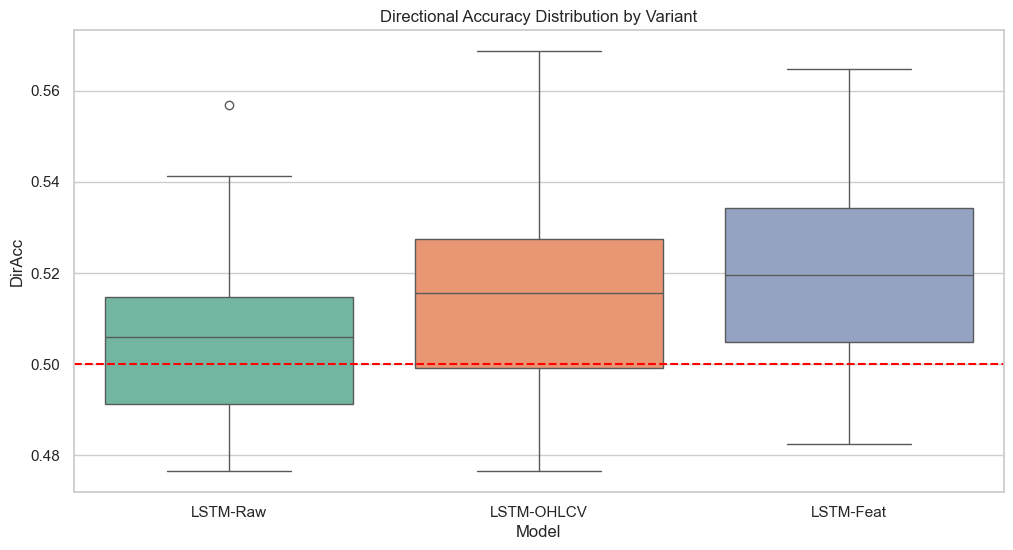

In [6]:
summary = res_df.groupby("Model")[["MAE", "RMSE", "DirAcc"]].mean().sort_values("RMSE")
display(summary.style.background_gradient(cmap="Blues"))

plt.figure(figsize=(12, 6))
sns.boxplot(data=res_df, x="Model", y="DirAcc", palette="Set2")
plt.axhline(0.5, color='red', linestyle='--')
plt.title("Directional Accuracy Distribution by Variant")
plt.show()

# Stage 2: LSTM Sequence Modeling — Ablation Study

## What This Stage Does

Stage 2 builds on the baselines established in Stage 1 by introducing **deep learning** via LSTM (Long Short-Term Memory) networks for next-day return prediction. Instead of training a single LSTM, we run a structured **ablation study** — three LSTM variants that differ *only* in what information they receive as input, while keeping the architecture identical.

This answers a fundamental question in applied ML:

> **Does hand-crafted feature engineering help, or can a recurrent network learn everything it needs from raw data?**

---

## The Three Variants

| Variant | Inputs per Time Step | What It Tests |
|---------|---------------------|---------------|
| **LSTM-Raw** | Log return only (1 feature) | Can the LSTM discover patterns like volatility clustering and momentum purely from a single return stream? |
| **LSTM-OHLCV** | Log return + 5 minimally processed OHLCV features (6 features) | Does richer raw market data (intraday range, close position, volume dynamics) help without imposing assumptions like rolling windows? |
| **LSTM-Feat** | Log return + 4 engineered features (5 features) | Does explicit domain-knowledge engineering (rolling volatility, volume z-score, market return) give an edge over raw data? |

### OHLCV Features Explained

These are lightweight transformations of raw daily bars — no rolling windows, no cross-asset information:

| Feature | Formula | Intuition |
|---------|---------|-----------|
| `oc_return` | (close − open) / open | Intraday momentum — did price rise or fall during trading? |
| `hl_range` | (high − low) / close | Intraday volatility — how wide was the day's range? |
| `close_pos` | (close − low) / (high − low) | Where did price close within the day's range? (0 = at low, 1 = at high) |
| `log_vol` | log(1 + volume) | Absolute trading activity level |
| `vol_change` | log(volume_t / volume_{t−1}) | Change in trading activity — is interest rising or falling? |

### Engineered Features (from Stage 1)

| Feature | Description |
|---------|-------------|
| `roll_vol` | 20-day rolling standard deviation of log returns |
| `range_norm` | Normalized high-low range |
| `vol_zscore` | Volume z-score over 20-day window |
| `mkt_return` | SPY log return (market factor) |

---

## How It Works

### Pipeline Overview

```
Download 12 tickers (same universe as Stage 1)
        │
        ▼
Compute all features (unshifted — windowing handles lag)
        │
        ▼
For each variant × each ticker:
        │
        ├── Slice relevant feature columns
        ├── Create lookback sequences: [t−20 … t−1] → predict return at t
        ├── Split: 70% train / 10% val / 20% test
        ├── Fit StandardScaler on train only
        ├── Train LSTM with early stopping
        ├── Predict on test set
        └── Record MAE, RMSE, Directional Accuracy
        │
        ▼
Compare all 3 variants (+ Stage 1 baselines if available)
```

### Avoiding Data Leakage

A critical concern with time series + deep learning. Here's how each source of leakage is prevented:

| Leakage Risk | Mitigation |
|--------------|------------|
| Future data in features | No features are shifted. Instead, the sequence window `[t−20 … t−1]` naturally uses only past data to predict day `t`. |
| Future data in scaling | `StandardScaler` is fit **only on training data**, then applied to val/test via `transform()`. |
| Future data in splits | Chronological split — no shuffling. Train comes before val comes before test. |
| Cross-validation bleed | No cross-validation. Single forward split preserves temporal ordering. |

### LSTM Architecture

```
Input (batch, 20, F)
    │
    ▼
LSTM ── 2 layers, 64 hidden units, dropout 0.2 between layers
    │
    ▼
Last hidden state (batch, 64)
    │
    ▼
Linear(64, 32) → ReLU → Linear(32, 1)
    │
    ▼
Scalar prediction: next-day log return
```

**Why this architecture?**

- **2 layers, 64 units** — small enough to train on ~2,500 samples per ticker without severe overfitting, large enough to capture nonlinear temporal patterns.
- **Last hidden state only** — the final time step's hidden state summarises the entire input sequence. Simpler and more stable than attention over all steps (that's Stage 3).
- **MLP head** — a single linear layer would limit the model to linear mappings from hidden state to prediction. The ReLU layer adds one more nonlinear transformation.

### Training Details

| Setting | Value | Why |
|---------|-------|-----|
| Optimizer | Adam | Standard; adapts learning rates per parameter |
| Learning rate | 1e-3 | Default starting point for Adam |
| Loss | MSE | Standard for regression; directly optimises RMSE |
| Batch size | 64 | Balances gradient noise and training speed |
| Max epochs | 100 | Upper bound; rarely reached due to early stopping |
| Early stopping patience | 10 | Stops training if validation loss doesn't improve for 10 consecutive epochs |
| Gradient clipping | max_norm = 1.0 | Prevents exploding gradients, common with LSTMs |
| Seed | 42 (reset per variant × ticker) | Ensures identical weight initialisation and data shuffling across variants for fair comparison |

---

## What to Expect

### Realistic Expectations

Daily stock returns are **extremely noisy**. The signal-to-noise ratio is very low. You should expect:

- **MAE and RMSE** close to (but hopefully slightly below) the Stage 1 baselines
- **Directional accuracy** in the range of **48–54%** — even 52% is meaningful
- **LSTM-Raw will likely underperform** — 1 feature × 20 steps gives the network very little to work with given limited training data (~2,500 samples)
- **LSTM-Feat will likely perform best** — pre-computed rolling statistics compensate for the small dataset by injecting domain knowledge
- **LSTM-OHLCV is the interesting middle ground** — if it matches LSTM-Feat, it means the LSTM can extract useful patterns from raw market structure without hand-holding

### Possible Outcomes and Interpretation

| Outcome | What It Means |
|---------|---------------|
| LSTM-Feat > LSTM-OHLCV > LSTM-Raw | Feature engineering helps; the network can't efficiently rediscover rolling statistics from limited data |
| LSTM-OHLCV ≈ LSTM-Feat > LSTM-Raw | The LSTM learns its own features from rich raw data, but needs more than just returns |
| All three ≈ Stage 1 baselines | Daily returns are too noisy for LSTMs to add value over simple models (an honest and valid finding) |
| LSTM-Raw > others | The engineered features were actually adding noise; pure signal is better (unlikely but possible) |

**Any of these outcomes is a valid and interesting result.** The goal is not to "win" but to understand *when and why* complexity helps.

---

## Outputs

### Files

| File | Description |
|------|-------------|
| `stage2_results.csv` | MAE, RMSE, DirAcc for every (ticker, variant) pair |
| `stage2_all_predictions.csv` | Actual vs predicted values for all test days |

### Plots

| Plot | What It Shows |
|------|---------------|
| `stage2_ablation_bars.png` | Mean MAE / RMSE / DirAcc across tickers for each variant |
| `stage2_ablation_per_ticker.png` | Grouped bar chart — RMSE by ticker with all 3 variants side by side |
| `stage2_ablation_curves.png` | Training vs validation loss over epochs (convergence and overfitting) |
| `stage2_ablation_predictions.png` | Actual vs predicted returns for a demo ticker (all 3 variants overlaid) |
| `stage2_ablation_heatmap.png` | Directional accuracy heatmap — ticker × variant |
| `stage2_full_comparison.png` | Combined comparison with Stage 1 baselines (if `stage1_results.csv` exists) |

---

## Connection to Other Stages

```
Stage 1: Baselines ──────────── "Can simple models predict returns?"
    │
Stage 2: LSTM (you are here) ── "Does sequential deep learning help?
    │                             Does feature engineering matter?"
    │
Stage 3: Transformer ────────── "Do attention mechanisms over the
    │                             sequence add value over LSTMs?"
    │
Stage 4: Probabilistic ──────── "Can we predict uncertainty,
    │                             not just point estimates?"
    │
Stage 5: Foundation Models ──── "Can a pretrained model match
    │                             custom-trained ones?"
    │
Stage 6: Latent Space ───────── "What structure exists in the
    │                             learned representations?"
    │
Stage 7: Final Comparison ───── "What did we learn?"
```

---

## How to Run

```bash
# Make sure Stage 1 has been run first (for comparison)
python stage1_baselines.py

# Run Stage 2
python stage2_lstm_ablation.py
```

**Requirements:** Python 3.9+, PyTorch, yfinance, scikit-learn, pandas, numpy, matplotlib, tqdm

**Runtime:** ~15–30 minutes on CPU (12 tickers × 3 variants), ~5 minutes on GPU.
